## Adversarial Attacks on Pre-trained Image Classification Models

***GOAL: Demonstrate how to use Tensorflow's auto-grad capability to manipulate an image classifier to give incorrect answers***

This notebook demonstrates how networks with very large numbers of inputs (in this case, 128x128x3 pixels), can be attacked through undetectable modifications to an input image.  We use Tensorflow's auto-differentiation capabilities to make tiny modifications to each pixel which cumulatively result in huge shifts in output probabilities.

**NOTE: The example data and pretrained model have been copied from the "Dogs vs. Cats" Kaggle competition page:**

  * Competition Page: https://www.kaggle.com/c/dogs-vs-cats
  * Solution Notebook: https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification
  
All credit to goes to Kaggle and the user "uysimty" for this base material.  The purpose of this notebook is not to identify deficiencies in the technical work done by "uysimty" but instead identify a risk vector of general neural-network architectures.

-----

## Model Achitecture
Here's the model architecture as shown from the Kaggle page:

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

There are three convolutional layers, followed by a flattening and an intermediate dense layer before the final two-neuron output layer, which produce probabilities of cat vs dog.  This is a standard convolutional neural net (CNN) architecture for image classification.

In fact, this is the epitome of "standard" image classifiers, emphasizing that our evil manipulations here are extremely general.  We're not exploiting any kind of unique quirk in the architecture.


-----

### Import Relevant Libraries

In [1]:
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Download the pre-trained model

In [2]:
import requests

if os.path.exists('./model.h5'):
    print('Model already exists locally, no need to download again')
else:
    # Pre-trained model weights are stored in my S3 bucket
    model_url = 'https://areiner-toptal-blog-resources.s3.amazonaws.com/dogs_and_cats/model.h5'
    with open('model.h5', 'wb') as f:
        f.write(requests.get(model_url).content)

    print(f'Finished downloading model weights to "model.h5"')

file_size_mb = os.stat('model.h5').st_size / (1024 * 1024.)
print(f'Model weights file is {file_size_mb:.1f}MB')

Model already exists locally, no need to download again
Model weights file is 49.4MB


## Define Constants

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMG_SIZE_2D = (IMG_WIDTH, IMG_HEIGHT)
IMG_SIZE_3D = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

## Recreate the Model Architecture, Load the Weights
The downloaded file is just the weights, without any architecture information.  Need to define the base architecture (copied from the project page) and then load those weights.

In [4]:
from tensorflow.keras import layers as L

x = inputs = L.Input(shape=IMG_SIZE_3D)
x = L.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE_3D)(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Dropout(0.25)(x)

x = L.Conv2D(64, (3, 3), activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Dropout(0.25)(x)

x = L.Conv2D(128, (3, 3), activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)
x = L.Dropout(0.25)(x)

x = L.Flatten()(x)
x = L.Dense(512, activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.5)(x)

x = outputs = L.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256   

In [5]:
model.load_weights('model.h5')

### A few methods for quickly running images through the classifier

In [6]:
def get_model_output(model, img3d):
    # Add batch dimension to predict with model, then remove extra dim in result
    return tf.squeeze(model.predict(tf.expand_dims(img3d, axis=0)))

def get_eval_str(model, img3d):
    CAT,DOG = 0,1
    probas = get_model_output(model, img3d)
    if probas[CAT] > probas[DOG]:
        pred_str, conf = 'CAT', f'{100*probas[CAT]:.1f}'
    else:
        pred_str, conf = 'DOG', f'{100*probas[DOG]:.1f}'
        
    line_1 = r'Predicted: $\bf{' + pred_str + '}$'
    line_2 = r'Confidence: $\bf{' + conf + '}$%'
    return line_1 + '\n' + line_2

Found 5 images in dir: ./sample_imgs
Example images:


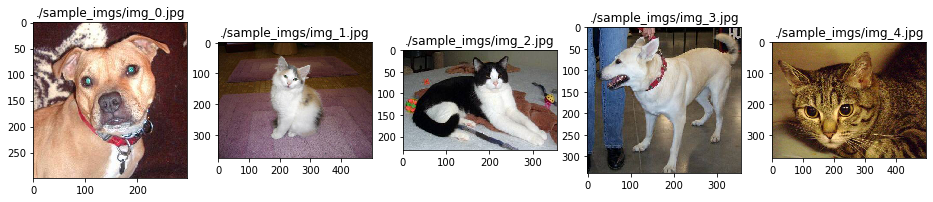

In [7]:
imgs_dir = './sample_imgs'
test_img_paths = sorted([f for f in os.listdir(imgs_dir) if not f.startswith('.')])
print(f'Found {len(test_img_paths)} images in dir: {imgs_dir}')
print(f'Example images:')

sample_imgs = {}
fig, axs = plt.subplots(1,5, figsize=(16,6))
for i in range(5):
    img_path = os.path.join(imgs_dir, test_img_paths[i])
    img = img_to_array(load_img(img_path), data_format='channels_last') / 256.
    sample_imgs[img_path] = img
    axs[i].imshow(img)
    axs[i].set_title(img_path)

-----

### Resize All Images and Test the Model
The model only takes input images of size (128, 128, 3), so let's resize them and then test that the model works.

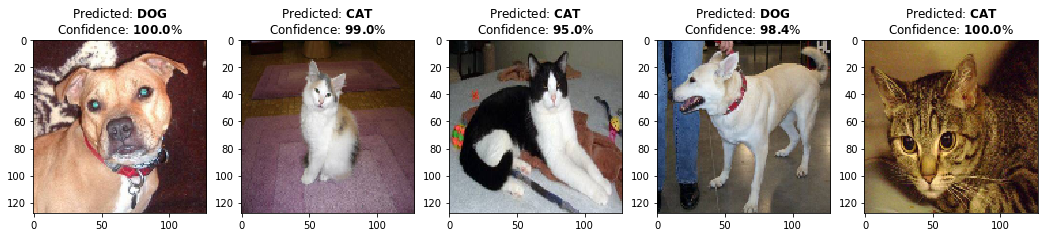

In [10]:
resz_imgs = dict([(fn, tf.image.resize(img, size=IMG_SIZE_2D)) for fn,img in sample_imgs.items()])

fig, axs = plt.subplots(1,5,figsize=(18,6))
i = 0
for fn,img in resz_imgs.items():
    axs[i].imshow(img)
    disp_str = get_eval_str(model, img)
    axs[i].set_title(disp_str)
    i += 1

The model is actually really good!  No wonder this is a top Notebook in this Kaggle competition.

-----

## Attacking the Model
Our goal is to determine how much we can manipulate the output probabilities without creating any human-distinguishable changes in the image.  So we will use Tensorflow's auto-grad to calculate the contribution of each pixel on the output probabilities, and then move each one exactly one count (1/256th brightness) in the direction of its gradient.  Since image pixels are encoded with counts values (0-255), any changes smaller than this would not affect the image when it is saved as a .jpg file again.

NOTE:  We are ignoring the magnitude of the gradients for the sake of moving in the smallest increments possible.  But we will do it three times.  So pixels with high gradients will move in the same direction all three times (+3, -3), while pixels with small gradients will end up moving back and forth (+1, -1).

In [11]:
def adversarial_modify(victim_img, to_dog=False, to_cat=False):
    # Make a copy of the input image
    orig_victim_img = victim_img[:, :, :]
    
    # Only diff in pushing probabilities towards dog or cat is gradient sign
    grad_dir = 1 if to_dog or not to_cat else -1
    
    fig, axs = plt.subplots(1, 5, figsize=(18,8))
    axs[0].imshow(victim_img)
    axs[0].set_title(get_eval_str(model, victim_img))
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    for i in range(4):

        # Auto-grad can only track tensors
        tf_victim_img = tf.convert_to_tensor(victim_img, dtype='float32')

        with tf.GradientTape() as tape:
            tape.watch(tf_victim_img)

            # Run the image through the model
            model_output = tf.squeeze(model(tf.expand_dims(tf_victim_img, axis=0)))

            # This is a picture of cat, let's try to make it evaluate as a dog
            loss = grad_dir * (model_output[0] - model_output[1])

        dloss_dimg = tape.gradient(loss, tf_victim_img)

        # Create masks to add exactly +1 pixel count to everything with positive grad, -1 for negative grad
        pixels_w_pos_grad = tf.cast(dloss_dimg > 0.0, 'float32') / 255.
        pixels_w_neg_grad = tf.cast(dloss_dimg < 0.0, 'float32') / 255.

        victim_img = tf.clip_by_value(victim_img - pixels_w_pos_grad + pixels_w_neg_grad, 0.0, 1.0)

        axs[i+1].imshow(victim_img)
        axs[i+1].set_title(f'{get_eval_str(model, victim_img)}')
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])
        
    return victim_img

## Let's try it out
Pay attention the classification and confidence values above each image

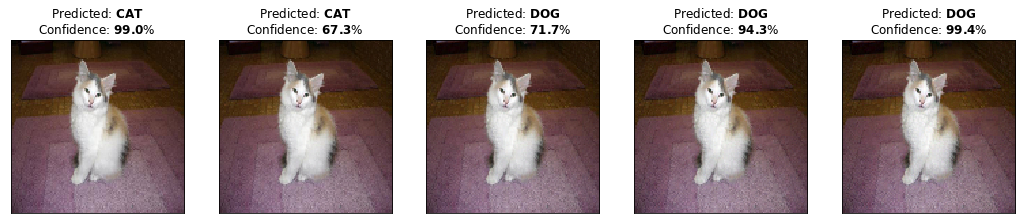

In [12]:
original_cat = resz_imgs['./sample_imgs/img_1.jpg']
victim_cat = adversarial_modify(original_cat, to_dog=True)

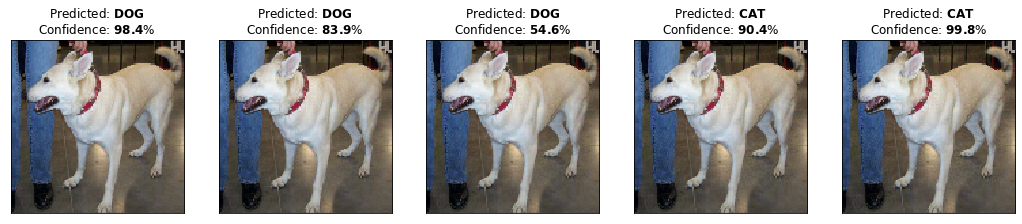

In [13]:
original_dog = resz_imgs['./sample_imgs/img_3.jpg']
victim_dog = adversarial_modify(original_dog, to_cat=True)

## Wow that was effective!
Let's look at some individual pixels just to confirm it did was we expected it to

In [14]:
def display_patch(img, title, xyhw=(60,60,6,6), ax=None, disp_type='img'):
    if ax is None:
        _,ax = plt.subplots(figsize=(4,4))
        
    # Take a spatial patch, and just the RED channel (0)
    x,y,h,w = xyhw
    disp_img = tf.cast(256.0 * img[x:x+h, y:y+h, 0], dtype='int32')
    cmap = sns.diverging_palette(220, 10,  as_cmap=True)
    
    heatmap_kwargs = {'annot': True, 'ax': ax, 'linewidths': 0.5, 'cbar': False, 'fmt': 'd', 'cmap': cmap}
    
    # Adjust color scale for diff images to avoid over-emphasizing colors
    if disp_type == 'diff':
        heatmap_kwargs['vmin'] = -12
        heatmap_kwargs['vmax'] =  12
        
    sns.heatmap(disp_img, **heatmap_kwargs)
        
    ax.set_xticklabels([f'{r}' for r in range(x, x+h)])
    ax.set_yticklabels([f'{c}' for c in range(y, y+h)])
    ax.set_xlabel('Pixel Column')
    ax.set_ylabel('Pixel Row')
    ax.set_title(title)
    ax.set_aspect(1.0)

### Compare the original and final cat images

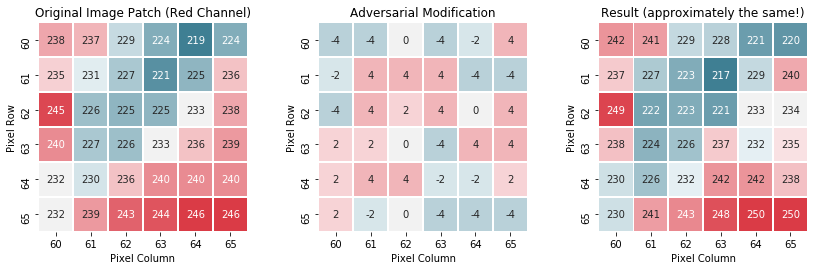

In [15]:
diff_img = original_cat - victim_cat

# These palettes help 
fig,axs = plt.subplots(1,3, figsize=(12,6))
display_patch(original_cat, 'Original Image Patch (Red Channel)', ax=axs[0])
display_patch(diff_img, 'Adversarial Modification', ax=axs[1], disp_type='diff')
display_patch(victim_cat, 'Result (approximately the same!)', ax=axs[2])
plt.tight_layout(3)

As expected, we see that all the pixels have shifted only (-4, -2, 0, +2, +4) counts.  That's all it took to completely fool this otherwise high-confidence classifier!

In [45]:
# The model uses 
for idx,layer in enumerate(model.layers):
    print(f'Layer {idx:02d}: {layer.name}')

Layer 00: input_1
Layer 01: conv2d
Layer 02: batch_normalization
Layer 03: max_pooling2d
Layer 04: dropout
Layer 05: conv2d_1
Layer 06: batch_normalization_1
Layer 07: max_pooling2d_1
Layer 08: dropout_1
Layer 09: conv2d_2
Layer 10: batch_normalization_2
Layer 11: max_pooling2d_2
Layer 12: dropout_2
Layer 13: flatten
Layer 14: dense
Layer 15: batch_normalization_3
Layer 16: dropout_3
Layer 17: dense_1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


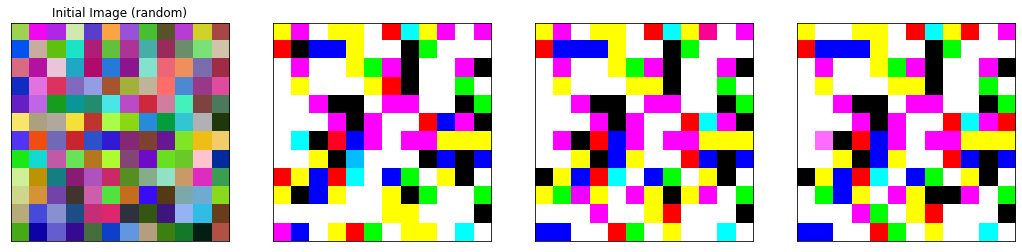

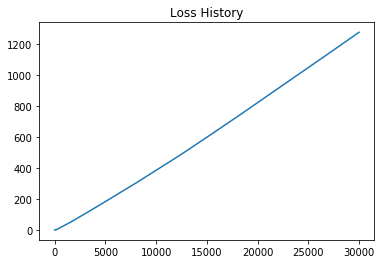

In [58]:
def maximize_model_output(model, layer_name, depth_index, patch_size=16):
    """
    We may want to either target both outputs at the same time, or just one
    without regard for what happens to the other.  In the latter case use
    a mask with 0.0 for the value we don't care about.
    """
    
    pad_sz = (IMG_WIDTH - patch_size) // 2
    padding_tensor = tf.constant([[pad_sz, pad_sz], [pad_sz, pad_sz], [0,0]])
    
    partial_model = keras.models.Model(
        inputs=model.inputs,
        outputs=model.get_layer(name=layer_name).output)
    
    dream_patch = tf.random.uniform(shape=(patch_size, patch_size, 3))
    learning_rate = 1.0
    

    fig, axs = plt.subplots(1,4, figsize=(18,8))
    axs[0].imshow(dream_patch)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title("Initial Image (random)")

    meansq_hist = []
    for i in range(3):

        for j in range(10000):
            with tf.GradientTape() as tape:
                tape.watch(dream_patch)
                padded_patch = tf.pad(dream_patch, padding_tensor)

                # Run the image through the model
                model_output = tf.squeeze(partial_model(tf.expand_dims(padded_patch, axis=0)))
                layer_meansq = tf.reduce_mean(model_output[:, :, depth_index])

            dlayerout_dimg = tape.gradient(layer_meansq, dream_patch)

            dream_patch = dream_patch + learning_rate * dlayerout_dimg
            meansq_hist.append(layer_meansq.numpy())
            

        axs[i+1].imshow(dream_patch)
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])

    fig,ax = plt.subplots()
    ax.plot(meansq_hist)
    ax.set_title('Loss History')

maximize_model_output(model, 'conv2d_2', 72, patch_size=12)

## Inspiration taken from this post, but using Tensorflow instead:
https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030